In [39]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
import sklearn.metrics as skmetrics
from sklearn.metrics import classification_report

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler,WeightedRandomSampler
import torchvision.models as models

from PIL import Image
import io
import pathlib

## Preprocessing and loading data

In [2]:
skip_training = False
device = torch.device('cuda:0')
image_information = pd.read_csv("data/HAM10000_metadata.csv")

In [3]:
image_information.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec),
basal cell carcinoma (bcc), 
benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl),
dermatofibroma (df),
melanoma (mel), 
melanocytic nevi (nv)
vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

In [4]:
image_information['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [5]:
classes = ['akiec','bcc','bkl','df','mel','nv','vasc']
#weights = [1/327,1/514, 1/1099, 1/115, 1/1113, 1/6705, 1/142]


#### Balancing training dataset

In [6]:
y = image_information.dx
X_train, X_val, y_train, y_test = train_test_split(y,y, test_size=0.2, stratify=y)

images_train_info = image_information.loc[y_train.index].reset_index(drop=True)
images_test_info = image_information.loc[y_test.index].reset_index(drop=True)

max_size = 2000
lst = [images_train_info]
for class_index, group in images_train_info.groupby('dx'):
    if len(group) < 2000:
        lst.append(group.sample(max_size-len(group), replace=True))
    
images_train_info = pd.concat(lst).reset_index(drop=True)

images_train_info['dx'].value_counts()

nv       5364
df       2000
bcc      2000
bkl      2000
akiec    2000
vasc     2000
mel      2000
Name: dx, dtype: int64

#### Adding data transformations (Feature engineering)

In [8]:
transform_train = transforms.Compose([
    transforms.Resize((299,299)), #inception-v3 accepts tensors of size Nx3x299x299
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

transform_test = transforms.Compose([
    transforms.Resize((299,299)), #inception-v3 accepts tensors of size Nx3x299x299
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

#### Defining custom dataloader for HAMN10000 dataset

In [9]:
class HAMN10000DataSet(Dataset):

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = csv_path
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['image_id'] + '.jpg' #name image id
        self.y = torch.from_numpy(np.array(df['dx'].astype('category').cat.codes, dtype=np.uint8)).long()
        self.y_str = df['dx'].values 
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label
    
    def __visualizeitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        label = self.y_str[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

#### Loading the dataset into dataloader

In [10]:
dataset_train = HAMN10000DataSet(csv_path=images_train_info,
                              img_dir='data/images', transform=transform_train)

dataset_test = HAMN10000DataSet(csv_path=images_test_info,
                              img_dir='data/images', transform=transform_test)

In [14]:
batchsize= 16

trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=batchsize, shuffle=False)

### Visualizing the dataset

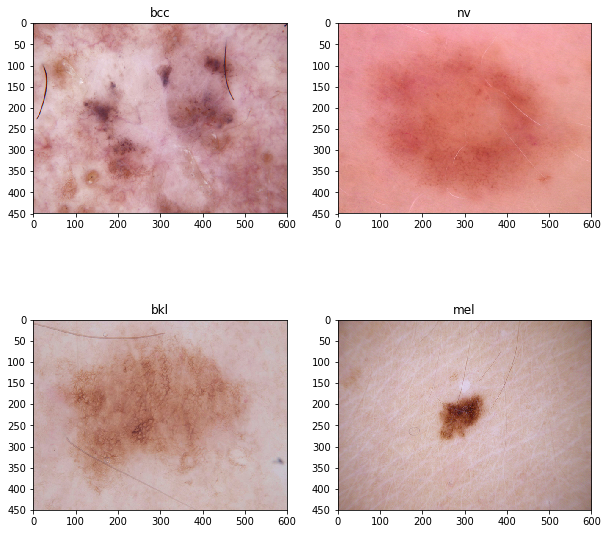

In [54]:
#Visualize random items from the training set (pretransformation)
img1, label1 = dataset_train.__visualizeitem__(100)
img2, label2 = dataset_train.__visualizeitem__(200)
img3, label3 = dataset_train.__visualizeitem__(500)
img4, label4 = dataset_train.__visualizeitem__(400)

f = plt.figure(figsize=(10,10))

ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)

ax1.imshow(img1)
ax1.title.set_text(label1)

ax2.imshow(img2)
ax2.title.set_text(label2)

ax3.imshow(img3)
ax3.title.set_text(label3)

ax4.imshow(img4)
ax4.title.set_text(label4)

## Training CNN

### training Inception-v3

In [21]:
net = models.inception_v3(pretrained=True)
net.AuxLogits.fc = nn.Linear(768, 7)
net.fc = nn.Linear(2048, 7) #inception-v3 output layer num_classes change from default 1000 to 7
net.to(device)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to C:\Users\Simo/.torch\models\inception_v3_google-1a9a5a14.pth
22.6%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

53.5%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

84.6%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--Noteboo

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [25]:
def compute_accuracy(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

n_epochs=10
accuracies = []

In [26]:
for epoch in range(n_epochs):
    net.train() #set net to train mode again otherwise auxillary values fail
    running_loss = 0.0
    print_every = 100  # mini-batches
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Transfer to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, aux_out = net(inputs) #inception model has auxillary output to handle vanishing gradient problem
        
        l1_loss = criterion(outputs, labels)
        l2_aux_loss = criterion(aux_out, labels)
        loss = l1_loss + 0.4* l2_aux_loss
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i % print_every) == (print_every-1):
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/print_every))
            running_loss = 0.0
        if skip_training:
            break

    accuracy = compute_accuracy(net, testloader)
    accuracies.append(accuracy)
    print('Accuracy of the network on the test images: %.3f' % accuracy)

print('Finished Training')

[1,   100] loss: 2.207
[1,   200] loss: 1.579
[1,   300] loss: 1.225
[1,   400] loss: 1.160
[1,   500] loss: 1.034
[1,   600] loss: 0.954
[1,   700] loss: 0.926
[1,   800] loss: 0.886
[1,   900] loss: 0.782
[1,  1000] loss: 0.733
Accuracy of the network on the test images: 0.793
[2,   100] loss: 0.676
[2,   200] loss: 0.655
[2,   300] loss: 0.649
[2,   400] loss: 0.611
[2,   500] loss: 0.624
[2,   600] loss: 0.617
[2,   700] loss: 0.614
[2,   800] loss: 0.604
[2,   900] loss: 0.574
[2,  1000] loss: 0.555
Accuracy of the network on the test images: 0.857
[3,   100] loss: 0.473
[3,   200] loss: 0.502
[3,   300] loss: 0.491
[3,   400] loss: 0.415
[3,   500] loss: 0.459
[3,   600] loss: 0.477
[3,   700] loss: 0.484
[3,   800] loss: 0.438
[3,   900] loss: 0.475
[3,  1000] loss: 0.474
Accuracy of the network on the test images: 0.836
[4,   100] loss: 0.399
[4,   200] loss: 0.396
[4,   300] loss: 0.384
[4,   400] loss: 0.381
[4,   500] loss: 0.330
[4,   600] loss: 0.390
[4,   700] loss: 0.330

### Saved model

In [27]:
# Save the network to a file, submit this file together with your notebook
filename = 'inception_v3_skin_cancer.pth'
if not skip_training:
    try:
        do_save = input('Do you want to save the model (type yes to confirm)? ').lower()
        if do_save == 'yes':
            torch.save(net.state_dict(), filename)
            print('Model saved to %s' % filename)
        else:
            print('Model not saved')
    except:
        raise Exception('The notebook should be run or validated with skip_training=True.')
else:
    net = Net()
    net.load_state_dict(torch.load(filename, map_location=lambda storage, loc: storage))
    net.to(device)
    print('Model loaded from %s' % filename)

Do you want to save the model (type yes to confirm)? yes
Model saved to inception_v3_skin_cancer.pth


## Visualizing the model

#### Heatmap

In [36]:
def confusion_matrix(net, testloader):
    net.eval()
    true_labels = []
    predictions = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            predicted = torch.argmax(outputs.data, 1)
            true_labels.append(labels.cpu().numpy())
            predictions.append(predicted.cpu().numpy())
    true_labels = np.hstack(true_labels)
    predictions = np.hstack(predictions)

    return true_labels, predictions

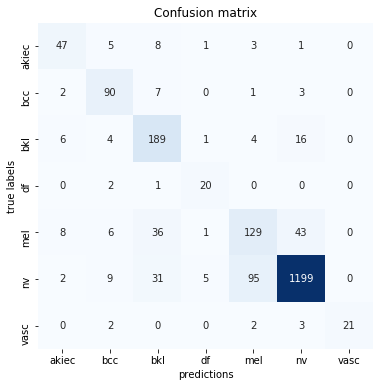

In [37]:
true_labels, predictions = confusion_matrix(net, testloader)
c_matrix = skmetrics.confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6, 6))
plt.title("Confusion matrix")
sns.heatmap(c_matrix, cmap='Blues', annot=True, xticklabels=classes, yticklabels=classes, fmt='g', cbar=False)
plt.xlabel('predictions')
plt.ylabel('true labels')

#### Linechart of precision

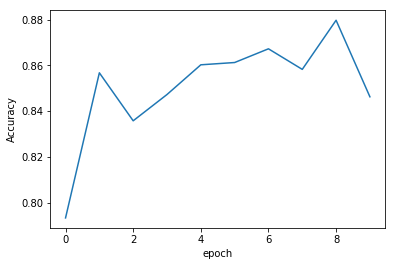

In [56]:
plt.plot(accuracies)
plt.xlabel('epoch')
plt.ylabel('Accuracy')

#### Detailed metrics

In [40]:
report = classification_report(true_labels, predictions, target_names=classes)
print(report)

              precision    recall  f1-score   support

       akiec       0.72      0.72      0.72        65
         bcc       0.76      0.87      0.81       103
         bkl       0.69      0.86      0.77       220
          df       0.71      0.87      0.78        23
         mel       0.55      0.58      0.56       223
          nv       0.95      0.89      0.92      1341
        vasc       1.00      0.75      0.86        28

   micro avg       0.85      0.85      0.85      2003
   macro avg       0.77      0.79      0.78      2003
weighted avg       0.86      0.85      0.85      2003



### Appendix

In [ ]:
#https://stackoverflow.com/questions/48373088/duplicating-training-examples-to-handle-class-imbalance-in-a-pandas-data-frame
#https://discuss.pytorch.org/t/custom-dataset-with-some-preprocessing/30385/2
#https://discuss.pytorch.org/t/problems-with-target-arrays-of-int-int32-types-in-loss-functions/140/2
#https://discuss.pytorch.org/t/cant-convert-np-ndarray-of-type-numpy-bool/32669
#https://discuss.pytorch.org/t/imagenet-example-with-inception-v3/1691/5
##https://discuss.pytorch.org/t/attributeerror-tuple-object-has-no-attribute-log-softmax/37309